In [12]:
# Import the pacakges 
# 
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
# Import internal functions 

from unet_2 import UNet_2
from utils.data_loading_2 import CarvanaDataset_2
from evaluate_2 import evaluate_2

In [17]:
# The path of data and model 

dir_model = 'Z:/Dongyu Fan/2. Data/ImageProcessing/training/2024-11-14/11-14_09-40/model_checkpoint_1.pth'
dir_img = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/img/'
dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/mask/'
dir_D = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/Diffusion/'

D_range = [0.1, 1]

In [14]:
def post_evaluation(model, val_loader):

    diffusion_pair = []
    for batch in val_loader:
        img, mask_true, D_true = batch['image'], batch['mask'], batch['D']
        mask_pred, D_pred = model(img)
        binary_mask = (torch.sigmoid(mask_pred) >= 0.5).float()
        true_results = (mask_true.float() * D_true).flatten().tolist()
        pred_results = (binary_mask * D_pred).flatten().tolist()
        pairs = [(a,b) for a,b in zip(true_results, pred_results) if a * b != 0]
        diffusion_pair.extend(pairs)

    return diffusion_pair
        



In [15]:
model


UNet_2(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [18]:
# 1. load the model 
# Initialize the model 
model = UNet_2(n_channels=3, n_classes=1,bilinear=False)
# Load the saved state_dict
model.load_state_dict(torch.load(dir_model,map_location=torch.device('cpu') ))
# Set to evaluation mode
model.eval()

# 2. Prepare the data loader 
# Prepare for the data set 
dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D, D_range, scale = 1)
#Split into train / validation partitions. Using the same seed used in training 
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0)) 

loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

# 3.  Perform evaluation
# Set up the device: 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mask_loss, diffusion_loss = evaluate_2(model,val_loader,device,amp=False)
diffusion_pair = post_evaluation(model, val_loader)





100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


In [19]:
mask_loss, diffusion_loss

(0.05670969139784574, 0.1717290685325861)

In [20]:
from sklearn.metrics import r2_score
def scatter_with_gaussian_kde( pair, s, diffusion_range):

    array = np.array(pair) * (diffusion_range[1] - diffusion_range[0]) + diffusion_range[0]
    xy = np.vstack(array).T
    z = gaussian_kde(xy)(xy)
    R2_sklearn = r2_score(xy[0], xy[1])

    plt.scatter( *zip(*array),c = z, s = s)
    plt.ylim([0,1])
    plt.xlabel(['Ground Truth diffusion coeficient'])
    plt.ylabel(['Predicted Diffusion coeficient'])
    return R2_sklearn

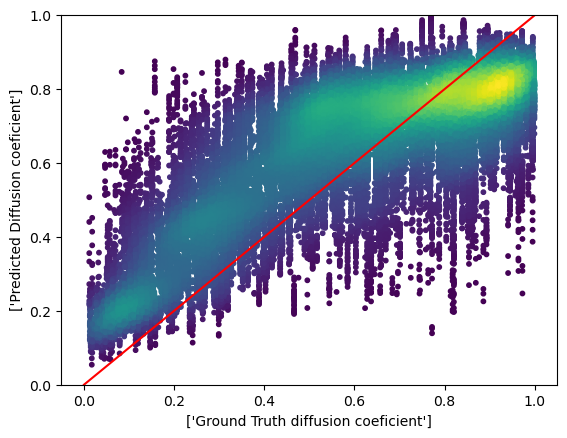

In [21]:
R2 = scatter_with_gaussian_kde(diffusion_pair,10,D_range)

plt.plot([0,1],[0,1], color = 'red')

In [22]:
R2 

0.5114168360787582

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 31036546


In [ ]:
model

UNet_2(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

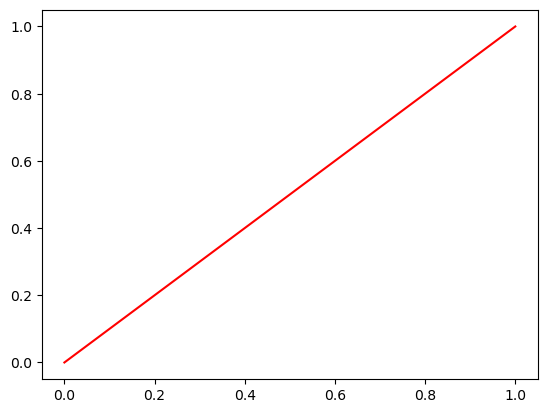

In [ ]:
plt.plot([0,1],[0,1], color = 'red')

(0.0, 1.0)

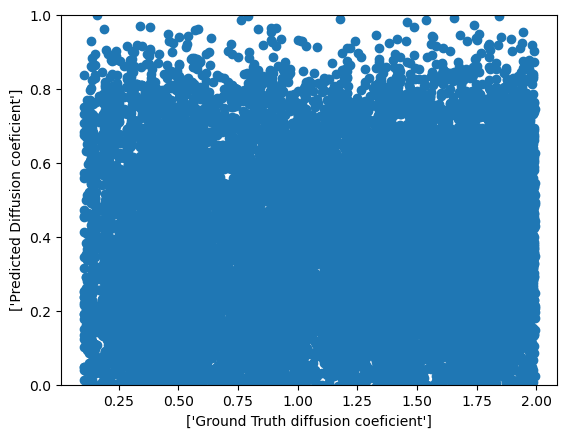

In [ ]:
# 4. Visualize the results 
plt.scatter(*zip(*diffusion_pair))
plt.xlabel(['Ground Truth diffusion coeficient'])
plt.ylabel(['Predicted Diffusion coeficient'])
plt.ylim([0,1])